In [1]:
import optax
import equinox as eqx
from jax import Array, numpy as jnp, random as jr, tree_util as jtu, vmap

from matplotlib import pyplot as plt

from rssm import (
    init_model,
    init_encoder,
    init_decoder,
    init_post_state,
    forward_encoder,
    forward_decoder,
    rollout_model,
    rollout_model_prior,
    rssm_loss,
)


In [2]:
@eqx.filter_jit
def train_step(params, obs_seq, action_seq, optimizer, opt_state, key):
    def loss_fn(params):
        o_loss, kl_loss = rssm_loss(params, obs_seq, action_seq, key)
        return o_loss + kl_loss

    loss, grads = eqx.filter_value_and_grad(loss_fn)(params)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = eqx.apply_updates(params, updates)
    return params, opt_state, loss


def make_sine_dataset(key: jr.PRNGKey, T: int, B: int) -> tuple[Array, Array]:
    t = jnp.linspace(0, 2 * jnp.pi, T)
    phases = jr.uniform(key, shape=(B,), minval=0, maxval=2 * jnp.pi)

    def per_batch(i):
        phase_i = phases[i]
        x = jnp.sin(t + phase_i)
        y = jnp.cos(t + phase_i)
        return jnp.stack([x, y], axis=-1)

    obs_seq = vmap(per_batch)(jnp.arange(B))
    action_seq = jnp.zeros((B, T, 1))
    return obs_seq, action_seq

In [ ]:
seed = 0
obs_dim = 2
action_dim = 1
obs_emb_dim = 16
state_dim = 32
rnn_hidden_dim = 64
mlp_hidden_dim = 128
batch_dim = 16
seq_len = 50

key = jr.PRNGKey(0)

key, k1, k2, k3 = jr.split(key, 4)
model = init_model(
    obs_emb_dim, action_dim, state_dim, rnn_hidden_dim, mlp_hidden_dim, k1
)
encoder = init_encoder(obs_dim, obs_emb_dim, mlp_hidden_dim, k2)
decoder = init_decoder(state_dim, rnn_hidden_dim, obs_dim, mlp_hidden_dim, k3)
params = (model, encoder, decoder)

optimizer = optax.adam(1e-4)
opt_state = optimizer.init(eqx.filter(params, eqx.is_inexact_array))

key, data_key = jr.split(key)
obs_seq, action_seq = make_sine_dataset(data_key, seq_len, batch_dim)


num_epochs = 1000
for epoch in range(num_epochs):
    key, train_key = jr.split(key)
    params, opt_state, loss = train_step(
        params, obs_seq, action_seq, optimizer, opt_state, train_key
    )
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

Epoch 0, Loss: 1.6816
Epoch 100, Loss: 1.0018
Epoch 200, Loss: 0.3410
Epoch 300, Loss: 0.2773
Epoch 400, Loss: 0.1996
Epoch 500, Loss: 0.1713
Epoch 600, Loss: 0.1900
Epoch 700, Loss: 0.1373
Epoch 800, Loss: 0.2222
Epoch 900, Loss: 0.1643


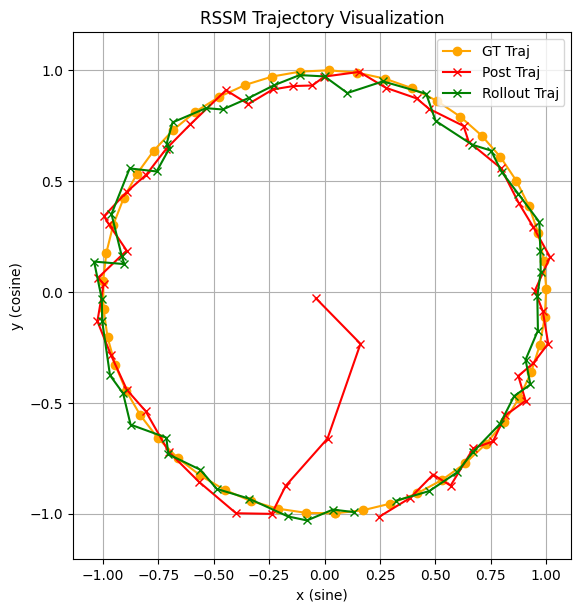

In [4]:
model, encoder, decoder = params

obs_slice = obs_seq[0]
action_slice = action_seq[0]

obs_embed_seq = vmap(lambda obs: forward_encoder(encoder, obs))(obs_slice)

key, rollout_key = jr.split(key)
init_post = init_post_state(model)
post_seq, _ = rollout_model(model, obs_embed_seq, init_post, action_slice, rollout_key)

key, prior_key = jr.split(key)
final_post = jtu.tree_map(lambda x: x[-1], post_seq)
rollout_seq = rollout_model_prior(model, final_post, action_slice, prior_key)

post_obs = vmap(lambda st: forward_decoder(decoder, st))(post_seq)
rollout_obs = vmap(lambda st: forward_decoder(decoder, st))(rollout_seq)

plt.figure(figsize=(6, 6))
plt.plot(
    obs_slice[:, 0],
    obs_slice[:, 1],
    label="GT Traj",
    marker="o",
    color="orange",
)
plt.plot(
    post_obs[:, 0],
    post_obs[:, 1],
    label="Post Traj",
    marker="x",
    color="red",
)
plt.plot(
    rollout_obs[:, 0],
    rollout_obs[:, 1],
    label="Rollout Traj",
    marker="x",
    color="green",
)
plt.legend()
plt.xlabel("x (sine)")
plt.ylabel("y (cosine)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.title("RSSM Trajectory Visualization")
plt.show()